# Launch dask cluster

We first launch a cluster and import it in the notebook, it should look like this :

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38509")
client

<Client: 'tcp://127.0.0.1:38509' processes=4 threads=16, memory=58.88 GiB>

# Import libraries

We load basic libraries (numpy, xarray, matplotlib, scipy) and one more specific :
  - xrft for Fourier transforms compatible with xarray : https://xrft.readthedocs.io/en/latest/


In [2]:
import numpy as np
import xarray as xr
import xrft
from scipy.interpolate import griddata
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cmocean
%matplotlib inline

# Call data

We open eNATL60 dataset : it is the Gulf Stream extraction of surface hourly data for 3 months

In [3]:
store='https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/swot_adac/eNATL60/Region01/surface_hourly/fma.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})
ds

<xarray.Dataset>
Dimensions:        (y: 763, x: 611, time_counter: 2136)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

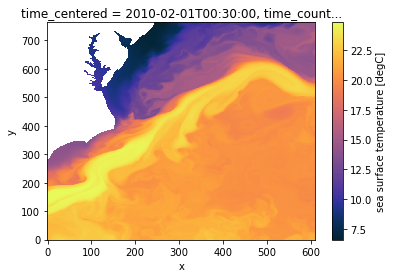

In [4]:
ds.sosstsst[0].plot(cmap=cmocean.cm.thermal)

To compare multiple datasets, a local catalog has been designed : [catalog.yaml](catalog.yaml)

It allows an easy access to the datasets.

Let's have a look at all the simulations that have been uploaded on the cloud :

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()

for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""    {params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("    Not implemented.")
    print()

GIGATL parameters and their allowable args are:
    region: ['1', '2']
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

HYCOM25 parameters and their allowable args are:
    region: ['1', '2', '3', '4', '5']
    datatype: ['surface_hourly']
    season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
    region: ['1_GS', '2_GE', '3_MD']
    datatype: ['surf', 'int', 'int_wvel', 'grid']
    season: ['fma', 'aso', '']
    grid: ['grid', '']

eNATL60 parameters and their allowable args are:
    region: ['1', '2', '3']
    datatype: ['surface_hourly', 'interior_daily']
    season: ['fma', 'aso']

FESOM parameters and their allowable args are:
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
    region: ['1', '2', '3', '4']
    datatype: ['surface_hourly', 'interior_daily', 'grid']
    season: ['fma', 'aso', '']
    grid: ['bathymetry', 'meshmask', '']

FIO-COM32 parameters and their allowable args are:
    reg

In [6]:
# We can now access one dataset with a single line command
ds = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask()
ds

<xarray.Dataset>
Dimensions:        (y: 763, x: 611, time_counter: 2136)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

# Interpolate finite-volume velocities to tracer points

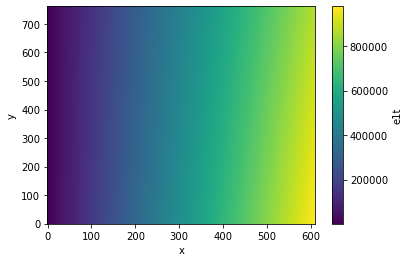

In [7]:
u = .5*(ds.sozocrtx.where(ds.umask!=0.) 
        + ds.sozocrtx.where(ds.umask!=0.).roll(x=-1)
       ).isel(x=slice(None,-1),y=slice(None,-1))
v = .5*(ds.somecrty.where(ds.vmask!=0.) 
        + ds.somecrty.where(ds.vmask!=0.).roll(y=-1)
       ).isel(y=slice(None,-1),x=slice(None,-1))
X = ds.e1t.cumsum('x').isel(y=slice(None,-1),x=slice(None,-1))
Y = ds.e2t.cumsum('y').isel(y=slice(None,-1),x=slice(None,-1))
X.plot()

# Interpolate onto uniform grid

In [8]:
ny, nx = X.shape
X = X - X.isel(x=nx//2)
xx = (X - X.isel(y=-1,x=0)).values.flatten()
yy = (Y - Y.isel(y=0)).values.flatten()
dx = ds.e1t.min().values
dy = ds.e2t.min().values
A = (ds.e1t * ds.e2t).isel(y=slice(None,-1),x=slice(None,-1))

xxx, yyy = np.mgrid[0:nx*dx:dx, 0:ny*dy:dy]

In [10]:
# weight each cell by its area (A)
Aterp = griddata((xx, yy),
                 A.values.flatten(),
                 (xxx, yyy) 
                ).T 

In [11]:
uterp = xr.DataArray(np.ones_like(u[::240]), dims=['time','YC','XC'],
                     coords={'time':ds.time_counter[::240].data,
                             'YC':np.arange(0,ny*dy,dy),
                             'XC':np.arange(0,nx*dx,dx)}
                    )
vterp = xr.DataArray(np.ones_like(v[::240]), dims=['time','YC','XC'],
                     coords={'time':ds.time_counter[::240].data,
                             'YC':np.arange(0,ny*dy,dy),
                             'XC':np.arange(0,nx*dx,dx)}
                    )

for it in range(len(ds.time_counter[::240])):
    uterp.isel(time=it)[:] = griddata((xx, yy),
                                      (u[::240]*A).isel(time_counter=it).values.flatten(),
                                      (xxx, yyy) 
                                     ).T 
    vterp.isel(time=it)[:] = griddata((xx, yy), 
                                      (v[::240]*A).isel(time_counter=it).values.flatten(),
                                      (xxx, yyy) 
                                     ).T
    
uterp /= Aterp
vterp /= Aterp

/tmp/ipykernel_792/3249335335.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax1.pcolormesh((X - X.isel(y=-1,x=0)), (Y - Y.isel(y=0)),


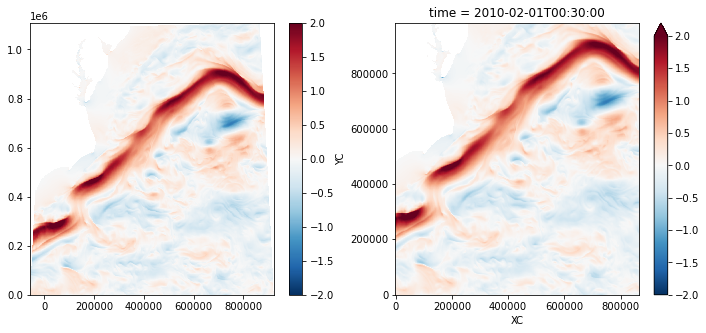

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

im = ax1.pcolormesh((X - X.isel(y=-1,x=0)), (Y - Y.isel(y=0)),
                    u.isel(time_counter=0),
                    vmin=-2, vmax=2, cmap='RdBu_r')
uterp.isel(time=0).plot(ax=ax2, vmin=-2, vmax=2, cmap='RdBu_r')

fig.colorbar(im, ax=ax1)

# Compute isotropic power spectra

In [13]:
Eu = xrft.isotropic_power_spectrum(uterp.fillna(0.), 
                                   dim=['YC','XC'], window='hann', detrend='linear', 
                                   true_phase=True, true_amplitude=True, 
                                   window_correction=True,
                                   truncate=True
                                  )
Ev = xrft.isotropic_power_spectrum(vterp.fillna(0.), 
                                   dim=['YC','XC'], window='hann', detrend='linear', 
                                   true_phase=True, true_amplitude=True,
                                   window_correction=True,
                                   truncate=True
                                  )

Text(0, 0.5, '[(m$^2$ s$^{-2}$) / cpm]')

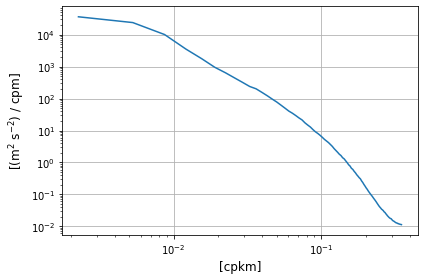

In [14]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.plot(Eu.freq_r*1e3, .5*(Eu+Ev).mean('time')*2*np.pi)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

ax.set_xlabel(r"[cpkm]", fontsize=12)
ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=12)

In [15]:
# save the results to be used in another plot
ds_specEu=Eu.to_dataset(name='Eu')
ds_specEv=Ev.to_dataset(name='Ev')

ds_specEu.to_netcdf('results/spec_Eu_eNATL60_fma.nc')
ds_specEv.to_netcdf('results/spec_Ev_eNATL60_fma.nc')



In [16]:
dsU=xr.open_dataset('results/spec_Eu_eNATL60_fma.nc')
dsV=xr.open_dataset('results/spec_Ev_eNATL60_fma.nc')

Text(0, 0.5, '[(m$^2$ s$^{-2}$) / cpm]')

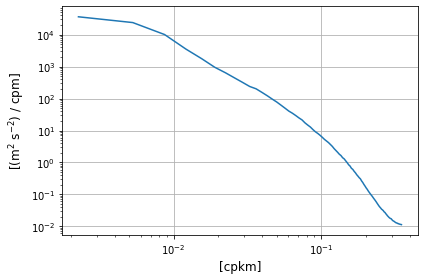

In [17]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.plot(dsU['freq_r']*1e3, .5*(dsU['Eu']+dsV['Ev']).mean('time')*2*np.pi)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

ax.set_xlabel(r"[cpkm]", fontsize=12)
ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=12)

## Now it is up to you

Duplicate this notebook and try to apply it to one of this option :

  - another variable
  - another period
  - another simulation
  
Then put the results in the shared-readwrite so we can make one recapitulative plot !